In [ ]:
import os
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, Conv1D, MaxPooling1D, Reshape, BatchNormalization, GlobalAveragePooling1D, LeakyReLU
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import logging
import matplotlib.pyplot as plt

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

TRAIN_DIR = 'data\\Train'
TEST_DIR = 'data\\Test'

# Define the class names
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling',
           'gun_shot', 'jackhammer', 'siren', 'street_music']

# Preprocessing

In [ ]:
def time_shift(audio, shift):
    """Shift the audio to the left or right by a random amount."""
    if shift <= 0:
        return audio
    shift_amount = np.random.randint(-shift, shift)
    return np.roll(audio, shift_amount, axis=1)

def pitch_shift(audio, sr, pitch):
    """Shift the pitch of the audio by a random amount."""
    if pitch <= 0:
        return audio
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.randint(-pitch, pitch))

In [ ]:
def preprocess_file(filepath, sr=22050, ch=2, duration=4):
    """Preprocess an audio file by converting it to mono, resampling, and trimming/padding"""
    try:
        audio, sr = librosa.load(filepath, sr=sr, mono=False)
        if audio.ndim == 1:
            audio = np.repeat(audio.reshape(1, -1), ch, axis=0)
            
        audio = time_shift(audio, 1)
        audio = pitch_shift(audio, sr, 1)

        target = int(sr * duration)
        if len(audio.T) < target:
            padding = target - len(audio.T)
            audio = np.pad(audio, ((0, 0), (0, padding)), mode='constant')
        else:
            audio = audio[:, :target]
        return audio, sr
    except Exception as e:
        logging.error(f"Error in conversion: {e}")
        return None, None

def preprocess_dataset(directory):
    """Preprocess all audio files in a directory and return audio data and labels."""
    preprocessed_data = []
    labels = []
    for file in tqdm(os.listdir(directory), desc=f"Preprocessing {directory}"):
        if file.endswith('.wav'):
            filepath = os.path.join(directory, file)
            audio, sr = preprocess_file(filepath)
            if audio is not None:
                label = file.split('__')[-1].split('.')[0]
                if label in classes:
                    preprocessed_data.append(audio)
                    labels.append(classes.index(label))
                else:
                    logging.warning(f"Skipping file with unknown label: {file}")
    return preprocessed_data, labels

In [ ]:
# Preprocess the dataset
train_data, train_labels = preprocess_dataset(TRAIN_DIR)
test_data, test_labels = preprocess_dataset(TEST_DIR)

# Extract features

In [ ]:
def add_noise(audio, noise_factor=0.0005):
    """Add random noise to the audio."""
    noise = np.random.randn(*audio.shape) * noise_factor
    return audio + noise

In [ ]:
def extract_features_ch(ch_data, sr=44100):
    mfcc = librosa.feature.mfcc(y=ch_data, sr=sr, n_mfcc=40)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc = np.mean(mfcc.T, axis=0)
    mfcc_delta= np.mean(mfcc_delta.T, axis=0)
    spec = np.mean(librosa.feature.melspectrogram(y=ch_data, sr=sr).T, axis=0)
    spec_contrast = np.mean(librosa.feature.spectral_contrast(y=ch_data, sr=sr).T, axis=0)
    spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=ch_data, sr=sr).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=ch_data).T, axis=0)

    mfcc = add_noise(mfcc)
    mfcc_delta = add_noise(mfcc_delta)
    spec = add_noise(spec)
    spec_contrast = add_noise(spec_contrast)
    spec_rolloff = add_noise(spec_rolloff)
    zcr = add_noise(zcr)
    return np.concatenate([mfcc, mfcc_delta, spec, spec_contrast, spec_rolloff, zcr])

def extract_features(data, sr=44100):
    """Extract MFCC and spectral features from audio data."""
    features = []
    for audio in tqdm(data, desc="Extracting features"):
        ch_1_features = extract_features_ch(audio[0], sr)
        ch_2_features = extract_features_ch(audio[1], sr)
        stereo_features = np.concatenate([ch_1_features, ch_2_features])
        features.append(stereo_features)
    return np.array(features, dtype=np.float32)

In [ ]:
# Extract features
train_features = extract_features(train_data)

test_features = extract_features(test_data)

In [ ]:
scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)

scaler.fit(test_features)
test_features = scaler.transform(test_features)

In [ ]:
# Remove outlier samples
iso_forest = IsolationForest(contamination='auto')

# fit model, predict outliers
outliers = iso_forest.fit_predict(train_features)

# remove outliers
train_features = train_features[outliers == 1]
train_labels = np.array(train_labels)[outliers == 1]

In [ ]:
# Split the dataset into training and validation sets
labels = to_categorical(train_labels, num_classes=len(classes))
X_train, X_val, y_train, y_val = train_test_split(train_features, labels, test_size=0.2, random_state=42)

In [131]:
# Define the model
model = Sequential([
    Input(shape=X_train[0].shape),
    Reshape((-1, 1)),
    
    # First Convolutional Block
    Conv1D(32, 3, padding='same'),
    LeakyReLU(),
    MaxPooling1D(2),
    Dropout(0.2),

    # Second Convolutional Block
    Conv1D(64, 3, padding='same'),
    LeakyReLU(),
    MaxPooling1D(2),
    Dropout(0.2),

    # Third Convolutional Block
    Conv1D(128, 3, padding='same'),
    LeakyReLU(),
    MaxPooling1D(2),
    Dropout(0.2),

    Flatten(),

    # Dense Layer
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),

    # Output Layer
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_25 (Reshape)            │ (None, 434, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_81 (Conv1D)              │ (None, 434, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_80 (LeakyReLU)      │ (None, 434, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_79 (MaxPooling1D) │ (None, 217, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 217, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_82 (Conv1D)              │ (None, 217, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_81 (LeakyReLU)      │ (None, 217, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_80 (MaxPooling1D) │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 108, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_83 (Conv1D)              │ (None, 108, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_82 (LeakyReLU)      │ (None, 108, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_81 (MaxPooling1D) │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 128)            │       884,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 10)             │         1,29

 Total params: 1,246,026 (4.75 MB)

 Trainable params: 1,246,026 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

In [132]:
# Train the model
unique_classes = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=train_labels)
class_weight_dict = dict(zip(unique_classes, class_weights))

# save the best model
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, batch_size=1024, epochs=250, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[model_checkpoint, early_stopping])
# high epoch as the early stopping will stop the training when the model stops improving
# might need to lower batch size if running out of memory

# save the model
model.save('model.keras')

Epoch 1/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.1162 - loss: 2.2892 - val_accuracy: 0.1202 - val_loss: 2.2789
Epoch 2/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.1135 - loss: 2.2590 - val_accuracy: 0.1173 - val_loss: 2.2367
Epoch 3/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.1475 - loss: 2.2063 - val_accuracy: 0.2346 - val_loss: 2.1550
Epoch 4/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.1885 - loss: 2.1435 - val_accuracy: 0.3636 - val_loss: 2.0336
Epoch 5/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.2398 - loss: 2.0407 - val_accuracy: 0.3812 - val_loss: 1.9068
Epoch 6/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.2979 - loss: 1.9535 - val_accuracy: 0.4545 - val_loss: 1.7135
Epoch 7/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.3448 - loss: 1.8054 - val_accuracy: 0.5132 - val_loss: 1.5687
Epoch 8/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3779 - loss: 1.6882 - val_accuracy: 0.5601 - v

In [133]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9004 - loss: 0.5127 
Test loss: 0.4533582925796509, Test accuracy: 0.9090909361839294


In [134]:
# Make predictions on the val set
predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_val, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# Analyze the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.9090909090909091
Confusion Matrix:
[[46  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0  0 34  3  3  0  0  0  3  2]
 [ 0  1  3 22  2  1  1  0  1  1]
 [ 1  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 35  0  0  0  0]
 [ 0  0  0  1  1  0 14  0  0  0]
 [ 0  0  0  0  0  0  0 45  0  0]
 [ 0  0  0  1  0  0  0  0 29  0]
 [ 1  0  2  1  0  0  0  0  2 39]]


# Test and Evaluation

In [96]:
def predict(features):
    features = np.array(features)
    predictions = model.predict(features)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

In [135]:
model = load_model('model.keras')

category_counts = {label: [0, 0, 0] for label in classes}
total_file_count = 0

for i, label in enumerate(test_features):
    predicted_idx = predict([label])
    predicted_class = classes[predicted_idx[0]]
    true_class = classes[test_labels[i]]

    if predicted_class == true_class:
        category_counts[true_class][0] += 1
    else:
        category_counts[true_class][1] += 1
        category_counts[predicted_class][2] += 1

    total_file_count += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [136]:
# plot
sorted_categories = sorted(category_counts.keys(), key=lambda category: sum(category_counts[category]))
sorted_counts = [category_counts[category] for category in sorted_categories]

true_positives = np.array([count[0] for count in sorted_counts])
false_positives = np.array([count[1] for count in sorted_counts])
false_negatives = np.array([count[2] for count in sorted_counts])

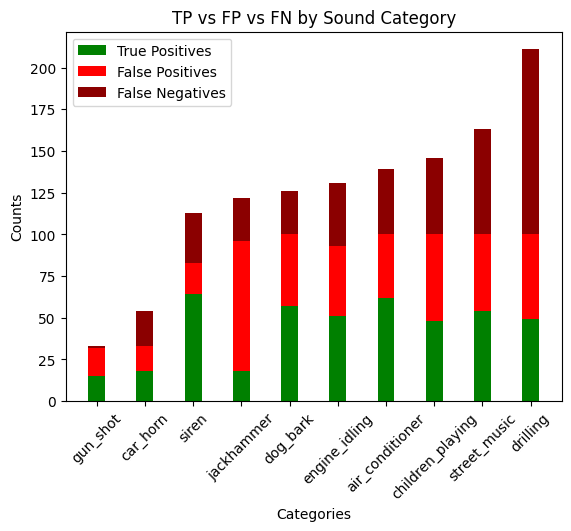

In [137]:
ind = np.arange(10)    
width = 0.35

p1 = plt.bar(ind, true_positives, width, color='green', label='True Positives')
p2 = plt.bar(ind, false_positives, width,  bottom=true_positives,color='red', label = 'False Positives')
p3 = plt.bar(ind, false_negatives, width,  bottom=true_positives+false_positives,color='darkred', label = 'False Negatives')

plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('TP vs FP vs FN by Sound Category')
plt.xticks(ind, sorted_categories, rotation = 45)
plt.legend()

plt.show()

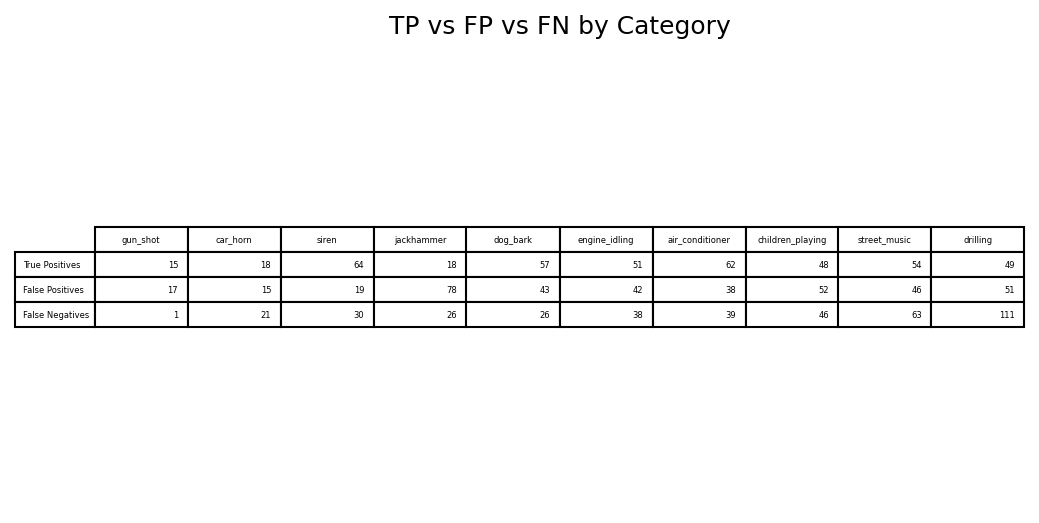

In [138]:
plt.figure(figsize=(8, 4), dpi = 150)
plt.table(cellText=[true_positives, false_positives, false_negatives],
          colLabels=sorted_categories,
          rowLabels=['True Positives', 'False Positives', 'False Negatives'],
          loc='center')
plt.axis('off')
plt.title('TP vs FP vs FN by Category')
plt.show()

In [139]:
print("accuracy: ", np.sum(true_positives)/total_file_count, "out of ", total_file_count)

accuracy:  0.5209080047789725 out of  837
